# Modeling 

In [6]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns 


# import additional libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

# functions from .py file
import src.eda_functions as fun


# Machine Learning Models
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import r2_score, SCORERS
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import warnings


In [8]:
# plot parameters
plt.figure(figsize=(20,16));
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 16

<Figure size 1440x1152 with 0 Axes>

read in merged_data file

In [9]:
train_set = pd.read_csv('../../data/train_set.csv')
val_set = pd.read_csv('../../data/val_set.csv')
test_set = pd.read_csv('../../data/test_set.csv')

In [10]:
train_set['cohort'] = train_set['cohort'].astype('object')
val_set['cohort'] = val_set['cohort'].astype('object')
test_set['cohort'] = test_set['cohort'].astype('object')

Separate X and y for each set

In [11]:
X_train = train_set.drop('high_school_4_year_graduation_rate_total', axis=1)
y_train = train_set.high_school_4_year_graduation_rate_total


X_val = val_set.drop('high_school_4_year_graduation_rate_total', axis=1)
y_val = val_set.high_school_4_year_graduation_rate_total

X_test = test_set.drop('high_school_4_year_graduation_rate_total', axis=1)
y_test = test_set.high_school_4_year_graduation_rate_total

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3403 entries, 0 to 3402
Data columns (total 28 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      3403 non-null   object 
 1   rcdts                                                                       3403 non-null   object 
 2   school_name                                                                 3403 non-null   object 
 3   district                                                                    3403 non-null   object 
 4   city                                                                        3403 non-null   object 
 5   county                                                                      3403 non-null   object 
 6   district_type                                   

In [13]:
X_test.isnull().sum().sort_values(ascending=False)

student_chronic_truancy_rate                                                  14
student_attendance_rate                                                       12
teacher_retention_rate                                                        12
avg_class_size_high_school                                                     9
total_number_of_school_days                                                    3
high_school_dropout_rate_total                                                 1
city                                                                           0
school_type                                                                    0
district_size                                                                  0
district_type                                                                  0
county                                                                         0
percent_9th_grade_on_track                                                     0
district                    

## Replace NaNs with mean()


Use SimpleImputer to replace NaNs with mean value

In [14]:
# identify features
train_num = X_train.select_dtypes(['float64', 'int64'])
val_num = X_val.select_dtypes(['float64', 'int64'])
test_num = X_test.select_dtypes(['float64', 'int64'])

In [15]:
from sklearn.impute import SimpleImputer

# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

# Train on the training features
imputer.fit(train_num)

# Transform both training data and testing data
train_imp= imputer.transform(train_num)
val_imp = imputer.transform(val_num)
test_imp = imputer.transform(test_num)

# Creating this DataFrame is not necessary its only to show the result of the ohe
X_train_imp = pd.DataFrame(train_imp, columns=train_num.columns, index=X_train.index)
X_val_imp = pd.DataFrame(val_imp, columns=val_num.columns, index=X_val.index)
X_test_imp = pd.DataFrame(test_imp, columns=test_num.columns, index=X_test.index)


#### Train set

In [16]:
X_train_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3403 entries, 0 to 3402
Data columns (total 18 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   percent_student_enrollment_white                                            3403 non-null   float64
 1   percent_student_enrollment_black_or_african_american                        3403 non-null   float64
 2   percent_student_enrollment_hispanic_or_latino                               3403 non-null   float64
 3   percent_student_enrollment_asian                                            3403 non-null   float64
 4   percent_student_enrollment_native_hawaiian_or_other_pacific_islander        3403 non-null   float64
 5   percent_student_enrollment_american_indian_or_alaska_native                 3403 non-null   float64
 6   percent_student_enrollment_two_or_more_races    

#### Val set

In [17]:
X_val_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721 entries, 0 to 720
Data columns (total 18 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   percent_student_enrollment_white                                            721 non-null    float64
 1   percent_student_enrollment_black_or_african_american                        721 non-null    float64
 2   percent_student_enrollment_hispanic_or_latino                               721 non-null    float64
 3   percent_student_enrollment_asian                                            721 non-null    float64
 4   percent_student_enrollment_native_hawaiian_or_other_pacific_islander        721 non-null    float64
 5   percent_student_enrollment_american_indian_or_alaska_native                 721 non-null    float64
 6   percent_student_enrollment_two_or_more_races      

#### Test set

In [18]:
X_test_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 18 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   percent_student_enrollment_white                                            720 non-null    float64
 1   percent_student_enrollment_black_or_african_american                        720 non-null    float64
 2   percent_student_enrollment_hispanic_or_latino                               720 non-null    float64
 3   percent_student_enrollment_asian                                            720 non-null    float64
 4   percent_student_enrollment_native_hawaiian_or_other_pacific_islander        720 non-null    float64
 5   percent_student_enrollment_american_indian_or_alaska_native                 720 non-null    float64
 6   percent_student_enrollment_two_or_more_races      

# Scaling Numeric features
- Standard Scaler

In [19]:
X_train_num = X_train_imp.select_dtypes(['float64', 'int64'])
X_val_num = X_val_imp.select_dtypes(['float64', 'int64'])
X_test_num = X_test_imp.select_dtypes(['float64', 'int64'])

In [20]:
ss = StandardScaler()

# Train on the training features
ss.fit(X_train_num)

# Transform both training data and testing data
X_train_sc= ss.transform(X_train_num)
X_val_sc = ss.transform(X_val_num)
X_test_sc = ss.transform(X_test_num)


X_train_sc = pd.DataFrame(X_train_sc, columns=X_train_num.columns, index=X_train.index)
X_val_sc = pd.DataFrame(X_val_sc, columns=X_val_num.columns, index=X_val.index)
X_test_sc = pd.DataFrame(X_test_sc, columns=X_test_num.columns, index=X_test.index)


# Encoding Categorical features

In [21]:
X_train_cat = X_train[['district_type', 'district_size', 'school_type']]
X_val_cat = X_val[['district_type', 'district_size', 'school_type']]
X_test_cat = X_test[['district_type', 'district_size', 'school_type']]

In [22]:
#let's change these objects to categories
X_train_cat.loc[:, ('district_type', 'district_size', 'school_type')].astype('category')
X_val_cat.loc[:, ('district_type', 'district_size', 'school_type')].astype('category')
X_test_cat.loc[:, ('district_type', 'district_size', 'school_type')].astype('category')

,district_type,district_size,school_type
0,UNIT,MEDIUM,HIGH SCHOOL
1,UNIT,MEDIUM,HIGH SCHOOL
2,UNIT,MEDIUM,HIGH SCHOOL
3,UNIT,MEDIUM,HIGH SCHOOL
4,UNIT,LARGE,HIGH SCHOOL
...,...,...,...
715,UNIT,LARGE,HIGH SCHOOL
716,UNIT,LARGE,HIGH SCHOOL
717,UNIT,LARGE,HIGH SCHOOL
718,HIGH SCHOOL,LARGE,HIGH SCHOOL


In [37]:
X_train_cat.district_type.str.rstrip()
X_train_cat.district_size.str.rstrip()
X_train_cat.school_type.str.rstrip()

0       HIGH SCHOOL
1       HIGH SCHOOL
2       HIGH SCHOOL
3       HIGH SCHOOL
4       HIGH SCHOOL
           ...     
3398    HIGH SCHOOL
3399    HIGH SCHOOL
3400    HIGH SCHOOL
3401    HIGH SCHOOL
3402    HIGH SCHOOL
Name: school_type, Length: 3403, dtype: object

In [38]:
X_val_cat['district_size'].unique()

array(['MEDIUM', 'LARGE', 'SMALL'], dtype=object)

In [39]:
X_train_cat['district_size'].unique()

array(['SMALL ', 'MEDIUM', 'LARGE '], dtype=object)

In [33]:
X_test_cat['district_size'].unique()

array(['MEDIUM', 'LARGE', 'SMALL'], dtype=object)

In [34]:
X_val_cat.district_type.str.rstrip()
X_val_cat.district_size.str.rstrip()
X_val_cat.school_type.str.rstrip()

0      HIGH SCHOOL
1      HIGH SCHOOL
2      HIGH SCHOOL
3      HIGH SCHOOL
4      HIGH SCHOOL
          ...     
716    HIGH SCHOOL
717    HIGH SCHOOL
718    HIGH SCHOOL
719    HIGH SCHOOL
720    HIGH SCHOOL
Name: school_type, Length: 721, dtype: object

In [35]:
X_test_cat.district_type.str.rstrip()
X_test_cat.district_size.str.rstrip()
X_test_cat.school_type.str.rstrip()

0      HIGH SCHOOL
1      HIGH SCHOOL
2      HIGH SCHOOL
3      HIGH SCHOOL
4      HIGH SCHOOL
          ...     
715    HIGH SCHOOL
716    HIGH SCHOOL
717    HIGH SCHOOL
718    HIGH SCHOOL
719    HIGH SCHOOL
Name: school_type, Length: 720, dtype: object

In [36]:
#encode the categoricals
ohe = OneHotEncoder(drop='first')

ohe.fit(X_train_cat)

X_train_ohe = ohe.transform(X_train_cat).toarray()
X_val_ohe = ohe.transform(X_val_cat).toarray()
X_test_ohe = ohe.transform(X_test_cat).toarray()

# Creating this DataFrame is not necessary its only to show the result of the ohe
X_train_processed = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names(X_train_cat.columns))
X_val_processed = pd.DataFrame(X_val_ohe, columns=ohe.get_feature_names(X_val_cat.columns))
X_test_processed = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names(X_test_cat.columns))

ValueError: Found unknown categories ['UNIT'] in column 0 during transform

In [ ]:
X_train_all = pd.concat([X_train_sc, X_train_processed], axis=1)
X_val_all = pd.concat([X_val_sc, X_val_processed], axis=1)
X_test_all = pd.concat([X_test_sc, X_test_processed], axis=1)


# 6. Test models
- Linear Regression
- Random Forest
- Gradient Boost
- Lasso
- Ridge
- SVM
- KNN

In [ ]:
# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_eval(model):
    
    # Train the model
    model.fit(X_train_all, y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_val_all)
    model_r2 = r2_score(y_val, model_pred)
    # Return the performance metric
    return model_r2

def cross_val(model):
    
    # Train the model
    model.fit(X_train_all, y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_val_all)
    #model_r2 = r2_score(y_val, model_pred)
    model_cv = cross_val_score(model, X_train_all, y_train)
    # Return the performance metric
    return model_cv

In [ ]:
linreg = LinearRegression()
linreg_r2 = fit_and_eval(linreg)
linreg_cv = cross_val(linreg)

print('Linear Regression Performance on the validation set: R2 = %0.4f' % linreg_r2)
print(f'Cross validation scores:{linreg_cv}' )

In [84]:
random_forest = RandomForestRegressor(random_state=19)
random_forest_r2 = fit_and_eval(random_forest)
random_forest_cv = cross_val(random_forest)

print('Random Forest Performance on the test set: R2 = %0.4f' % random_forest_r2)
print(f'Cross validation scores:{random_forest_cv}' )

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Random Forest Performance on the test set: R2 = 0.4526
Cross validation scores:[0.38836363 0.4265169  0.43670508]


In [85]:
extra_trees = ExtraTreesRegressor(random_state=19)
extra_trees_r2 = fit_and_eval(extra_trees)
extra_trees_cv = cross_val(extra_trees)

print('Extra Trees Performance on the test set: R2 = %0.4f' % extra_trees_r2)
print(f'Cross validation scores:{extra_trees_cv}' )

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Extra Trees Performance on the test set: R2 = 0.5548
Cross validation scores:[0.3329636  0.36965121 0.43941049]


In [86]:
grad_boost = GradientBoostingRegressor(random_state=19)
grad_boost_r2 = fit_and_eval(grad_boost)
grad_boost_cv = cross_val(grad_boost)


print('Gradient Boosted Performance on the test set: R2 = %0.4f' % grad_boost_r2)
print(f'Cross validation scores:{grad_boost_cv}' )

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Gradient Boosted Performance on the test set: R2 = 0.5584
Cross validation scores:[0.43282944 0.46064848 0.47424298]


In [87]:
# Create the model
lasso = Lasso(random_state=19)
lasso_r2 = fit_and_eval(lasso)
lasso_cv = cross_val(lasso)


print('Lasso model Performance on the test set: R2 = %0.4f' % lasso_r2)
print(f'Cross validation scores:{lasso_cv}' )

Lasso model Performance on the test set: R2 = 0.4901
Cross validation scores:[0.45313505 0.39671348 0.32075843]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [88]:
ridge = Ridge(random_state=19)
ridge_r2 = fit_and_eval(ridge)
ridge_cv = cross_val(ridge)


print('Ridge Model Performance on the test set: R2 = %0.4f' % ridge_r2)
print(f'Cross validation scores:{ridge_cv}' )

Ridge Model Performance on the test set: R2 = 0.5313
Cross validation scores:[0.47063841 0.41919454 0.30430406]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [89]:
svr = SVR()
svr_r2 = fit_and_eval(svr)
svr_cv = cross_val(svr)

print('Support Vector Machine Regression Performance on the test set: R2 = %0.4f' % svr_r2)
print(f'Cross validation scores:{svr_cv}' )

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto'

Support Vector Machine Regression Performance on the test set: R2 = 0.3937
Cross validation scores:[0.29351355 0.29741786 0.26991292]


In [90]:
knn = KNeighborsRegressor()
knn_r2 = fit_and_eval(knn)
knn_cv = cross_val(knn)

print('K-Nearest Neighbors Regression Performance on the test set: R2 = %0.4f' % knn_r2)
print(f'Cross validation scores:{knn_cv}' )

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


K-Nearest Neighbors Regression Performance on the test set: R2 = 0.4970
Cross validation scores:[0.2774694  0.30235057 0.31887353]


# 7. Select model

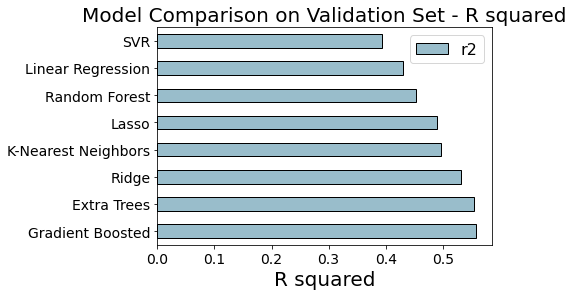

In [91]:
# Dataframe to hold the results
           
model_comparison = pd.DataFrame({'model': ['Linear Regression','Random Forest',
                                           'Extra Trees','Gradient Boosted',
                                           'Lasso', 'Ridge', 'SVR','K-Nearest Neighbors'],
                                 'r2': [linreg_r2, random_forest_r2, extra_trees_r2, 
                                         grad_boost_r2, lasso_r2, ridge_r2, svr_r2, knn_r2]})

# Horizontal bar chart of test r2
model_comparison.sort_values('r2', ascending = False).plot(x = 'model', y = 'r2', kind = 'barh',
                                                           color = '#99BDCB', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('R squared'); plt.xticks(size = 14)
plt.title('Model Comparison on Validation Set - R squared', size = 20);

Results....


# 8. grid search w cross val

In [92]:
# Loss function to be optimized
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

In [96]:
# Create the model to use for hyperparameter tuning
model = GradientBoostingRegressor(random_state = 19)

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25, 
                               scoring = 'r2',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=19)

In [ ]:
# Fit on the training data
random_cv.fit(X_train_all, y_train)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [95]:
# Find the best combination of settings
random_cv.best_estimator_


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=15,
                    max_features=None, max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=8, min_samples_split=4,
                    min_weight_fraction_leaf=0.0, n_estimators=1500,
                    n_jobs=None, oob_score=False, random_state=19, verbose=0,
                    warm_start=False)

# 9. train

In [ ]:
final_trees = ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=15,
                    max_features=None, max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=8, min_samples_split=4,
                    min_weight_fraction_leaf=0.0, n_estimators=1500,
                    n_jobs=None, oob_score=False, random_state=19, verbose=0,
                    warm_start=False)


final_trees_r2 = fit_and_eval(final_trees)

print('Extra Trees Performance on the test set: R2 = %0.4f' % extra_trees_r2)

In [ ]:
default_model = OLS
final_model = final_trees

# 10. evalutate on test set

In [ ]:
# Make predictions on the test set using default and final model
#default_pred = default_model.predict(X_test_all)
final_pred = final_model.predict(X_test_all)

# 11. Model interpretation
- feature impolrtances
 - create df & visualize
- plot single decision tree
- LIME

In [ ]:
lin_reg_model = LinearRegression()
baseline_cross_val_score = cross_val_score(lin_reg_model, X_train, y_train)
baseline_cross_val_score